In [1]:
import os
import csv

dataset_dir = "dataset"
csv_file = "metadata_mango.csv"

with open(csv_file, 'w', newline='') as csvfile:
    fieldnames = ['Filename', 'Disease']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for disease_folder in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, disease_folder)):
            disease_name = disease_folder
            image_files = os.listdir(os.path.join(dataset_dir, disease_folder))
            for image_file in image_files:
                # Convert relative path to absolute path
                image_path = os.path.abspath(os.path.join(dataset_dir, disease_folder, image_file))
                writer.writerow({'Filename': image_path, 'Disease': disease_name})



In [2]:
import csv

csv_file = "metadata_mango.csv"

with open(csv_file, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        print(row)


['Filename', 'Disease']
['d:\\Projects\\MangoLeafDiseaseDetection\\dataset\\Anthracnose\\20211008_124249 (Custom).jpg', 'Anthracnose']
['d:\\Projects\\MangoLeafDiseaseDetection\\dataset\\Anthracnose\\20211008_124250 (Custom).jpg', 'Anthracnose']
['d:\\Projects\\MangoLeafDiseaseDetection\\dataset\\Anthracnose\\20211008_124252 (Custom).jpg', 'Anthracnose']
['d:\\Projects\\MangoLeafDiseaseDetection\\dataset\\Anthracnose\\20211008_124253 (Custom).jpg', 'Anthracnose']
['d:\\Projects\\MangoLeafDiseaseDetection\\dataset\\Anthracnose\\20211008_124256 (Custom).jpg', 'Anthracnose']
['d:\\Projects\\MangoLeafDiseaseDetection\\dataset\\Anthracnose\\20211008_124301 (Custom).jpg', 'Anthracnose']
['d:\\Projects\\MangoLeafDiseaseDetection\\dataset\\Anthracnose\\20211008_124302 (Custom).jpg', 'Anthracnose']
['d:\\Projects\\MangoLeafDiseaseDetection\\dataset\\Anthracnose\\20211008_124305 (Custom).jpg', 'Anthracnose']
['d:\\Projects\\MangoLeafDiseaseDetection\\dataset\\Anthracnose\\20211008_124306 (Custom

In [3]:
import pandas as pd

# Load dataset
data = pd.read_csv("metadata_mango.csv")

# Assuming a 'Disease' column for labels
class_counts = data['Disease'].value_counts()

# Calculate the support proportion for each class
total_samples = len(data)
support_proportions = class_counts / total_samples

# Print the support proportions
print("Support Proportions:")
print(support_proportions)


Support Proportions:
Disease
Anthracnose         0.125
Bacterial Canker    0.125
Cutting Weevil      0.125
Die Back            0.125
Gall Midge          0.125
Healthy             0.125
Powdery Mildew      0.125
Sooty Mould         0.125
Name: count, dtype: float64


In [4]:
# 2nd model training code that stores the history during training

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv("metadata_mango.csv")

file_paths = data['Filename'].tolist()
labels = data['Disease'].tolist()

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

images = []
for file_path in file_paths:
    img = load_img(file_path, target_size=(224, 224))
    img = img_to_array(img) / 255.0
    images.append(img)

images = np.array(images)
labels = to_categorical(labels, num_classes=np.max(labels) + 1)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

batch_size = 32
num_classes = labels.shape[1]
num_epochs = 20

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator()

base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Assuming train_images and train_labels are numpy arrays
train_generator = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_generator = train_generator.repeat().batch(batch_size)

val_generator = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_generator = val_generator.repeat().batch(batch_size)

# Calculate steps_per_epoch
steps_per_epoch = len(train_images) // batch_size
validation_steps = len(val_images) // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=num_epochs,
)
  
test_loss, test_accuracy = model.evaluate(test_images, test_labels, batch_size=batch_size)

model.save("disease_detector.h5")

print(f"Test accuracy: {test_accuracy}")


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 699s 6s/step - accuracy: 0.8797 - loss: 0.4033 - val_accuracy: 0.1406 - val_loss: 2.3779
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - accuracy: 0.9967 - loss: 0.0116 - val_accuracy: 0.0781 - val_loss: 2.3471
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 598s 6s/step - accuracy: 0.9937 - loss: 0.0204 - val_accuracy: 0.1328 - val_loss: 2.5587
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 595s 6s/step - accuracy: 0.9995 - loss: 0.0031 - val_accuracy: 0.1719 - val_loss: 2.4323
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 471s 5s/step - accuracy: 0.9984 - loss: 0.0052 - val_accuracy: 0.2760 - val_loss: 2.1022
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 441s 4s/step - accuracy: 1.0000 - loss: 2.0637e-04 - val_accuracy: 0.4609 - val_loss: 1.6668
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - accuracy: 1.0000 - loss: 7.1746e-05 - val_accuracy: 0.6042 - val_loss: 1.2221
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - accuracy: 1.0000 - loss: 4.9194e-0

Test accuracy: 1.0


13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
Accuracy: 1.0000
Precision: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[56  0  0  0  0  0  0  0]
 [ 0 56  0  0  0  0  0  0]
 [ 0  0 55  0  0  0  0  0]
 [ 0  0  0 46  0  0  0  0]
 [ 0  0  0  0 52  0  0  0]
 [ 0  0  0  0  0 38  0  0]
 [ 0  0  0  0  0  0 51  0]
 [ 0  0  0  0  0  0  0 46]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        55
           3       1.00      1.00      1.00        46
           4       1.00      1.00      1.00        52
           5       1.00      1.00      1.00        38
           6       1.00      1.00      1.00        51
           7       1.00      1.00      1.00        46

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



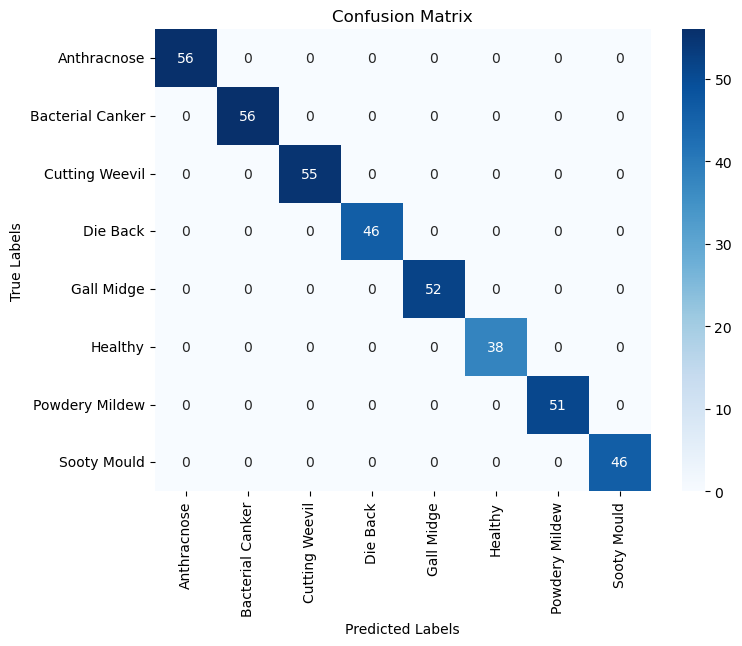

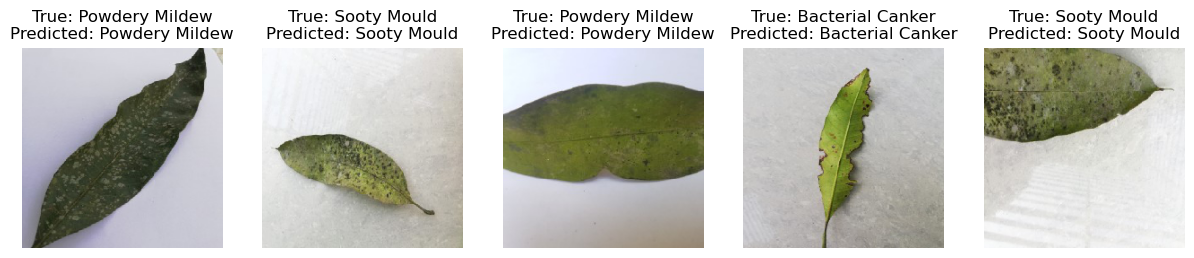

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load the model
# model = load_model("mango_disease_model.h5")
model = load_model("disease_detector.h5")

# Load the data
data = pd.read_csv("metadata_mango.csv")

file_paths = data['Filename'].tolist()
labels = data['Disease'].tolist()

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

images = []
for file_path in file_paths:
    img = load_img(file_path, target_size=(224, 224))
    img = img_to_array(img) / 255.0
    images.append(img)

images = np.array(images)
labels = to_categorical(labels, num_classes=np.max(labels) + 1)

# Split the data
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# Predictions on the test set
test_predictions = model.predict(test_images)
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print(f"Precision: {precision:.4f}")

# F1 Score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Plotting a few sample images with predictions
num_samples = 5
sample_indices = np.random.choice(len(test_images), num_samples, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices, 1):
    plt.subplot(1, num_samples, i)
    plt.imshow(test_images[idx])
    plt.title(f"True: {label_encoder.classes_[true_labels[idx]]}\nPredicted: {label_encoder.classes_[predicted_labels[idx]]}")
    plt.axis('off')
plt.show()


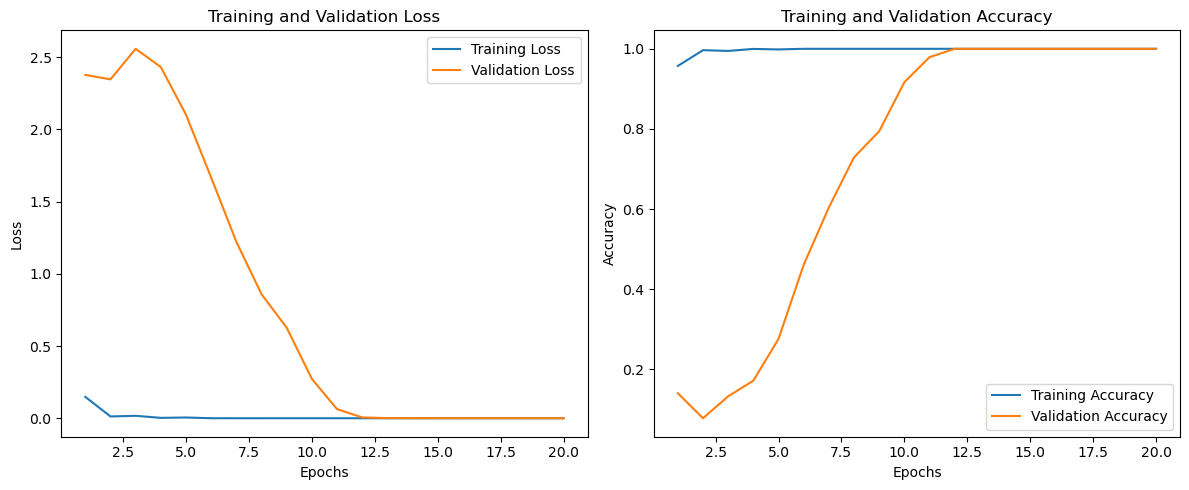

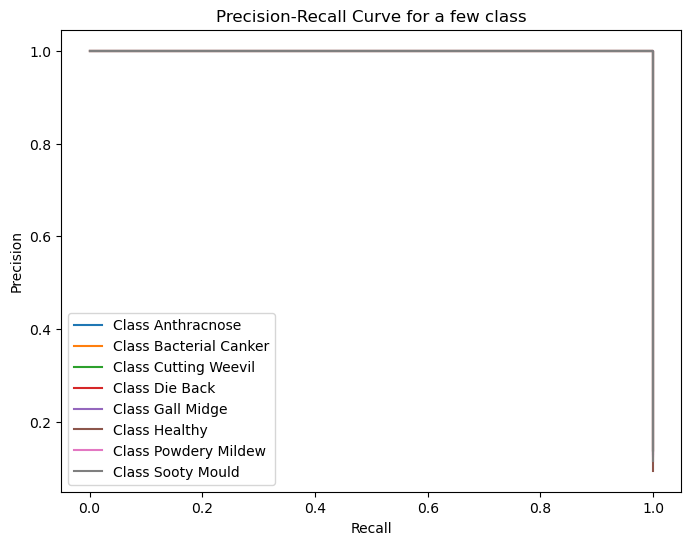

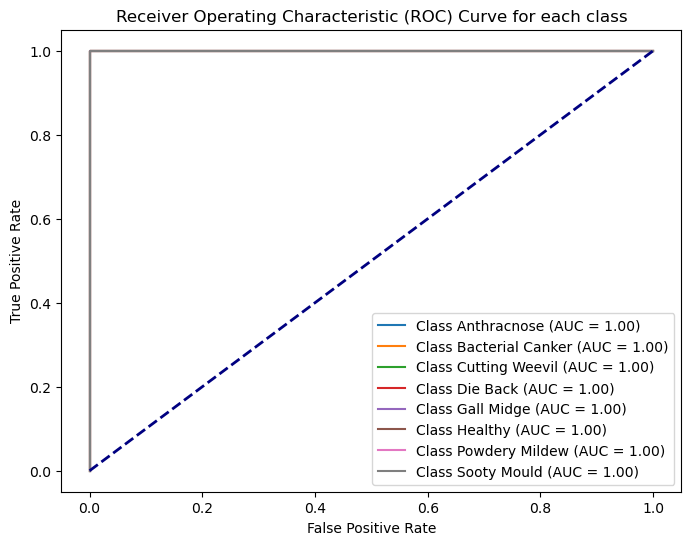

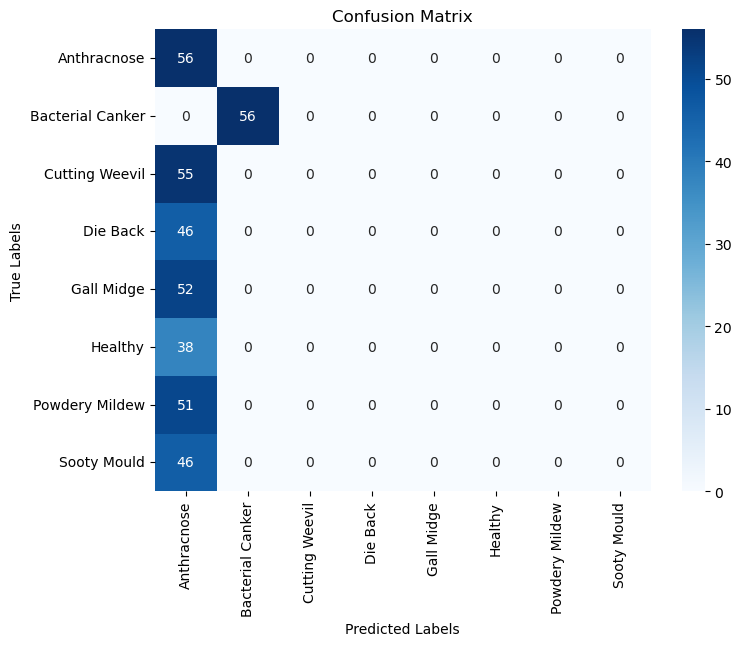

In [6]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
import seaborn as sns

# Extract information from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, num_epochs + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Binarize the true labels for precision-recall curve
binarized_labels = label_binarize(true_labels, classes=range(num_classes))

# Precision-Recall Curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    try:
        precision, recall, _ = precision_recall_curve(binarized_labels[:, i], test_predictions[:, i])
        plt.plot(recall, precision, label=f'Class {label_encoder.classes_[i]}')
    except IndexError:
        pass  # Ignore classes with no samples in the test set

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for a few class')
plt.legend()
plt.show()

# Convert true labels and predictions to one-hot encoded format
true_labels_one_hot = to_categorical(true_labels, num_classes=num_classes)
test_predictions_one_hot = to_categorical(np.argmax(test_predictions, axis=1), num_classes=num_classes)

# ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], test_predictions_one_hot[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for each class')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, (test_predictions[:, 1] > 0.5).astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


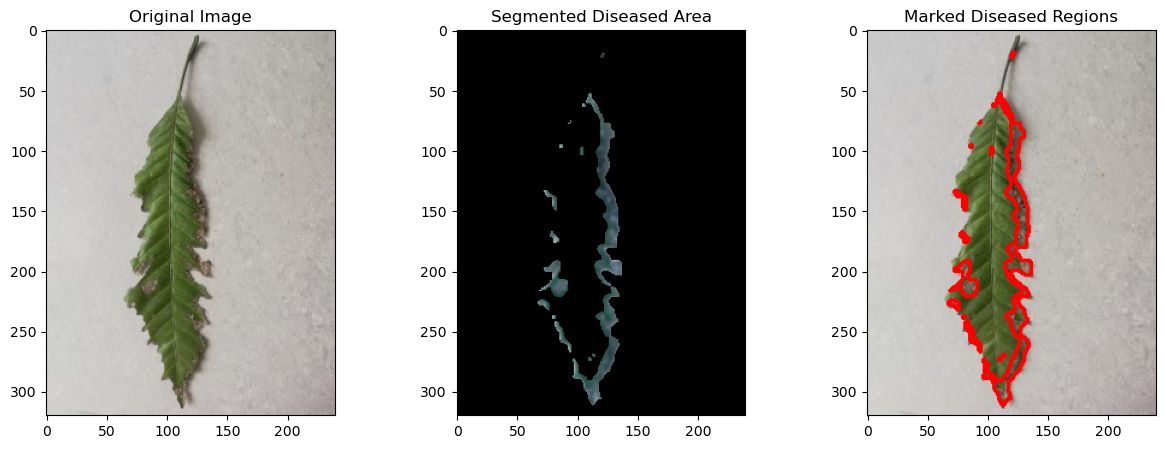

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    img = cv2.imread(image_path)
    
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}. Please check the path.")
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, img_rgb

def preprocess_image(img):
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
    return blurred_img

def segment_disease(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    lower_range1 = np.array([20, 50, 50])
    upper_range1 = np.array([35, 255, 255])
    
    lower_range2 = np.array([10, 50, 50])
    upper_range2 = np.array([25, 255, 255])
    
    mask1 = cv2.inRange(hsv_img, lower_range1, upper_range1)
    mask2 = cv2.inRange(hsv_img, lower_range2, upper_range2)
    
    combined_mask = cv2.bitwise_or(mask1, mask2)
    
    # Apply morphological operations to clean the mask
    kernel = np.ones((5, 5), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    
    # Use edge detection to capture finer details within the leaf
    edges = cv2.Canny(combined_mask, 100, 200)
    
    # Combine edges with the mask
    final_mask = cv2.bitwise_or(combined_mask, edges)
    
    # Apply the mask to the original image to highlight diseased areas
    result = cv2.bitwise_and(img, img, mask=final_mask)
    
    return final_mask, result

def mark_disease(img, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw contours or bounding boxes on the original image
    marked_img = img.copy()
    cv2.drawContours(marked_img, contours, -1, (255, 0, 0), 2)
    
    return marked_img


def display_images(original, processed, marked):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Original Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(processed)
    plt.title("Segmented Diseased Area")
    
    plt.subplot(1, 3, 3)
    plt.imshow(marked)
    plt.title("Marked Diseased Regions")
    
    plt.show()

def detect_and_mark_disease(image_path):
    img, img_rgb = load_image(image_path)
    preprocessed_img = preprocess_image(img)
    mask, segmented_img = segment_disease(preprocessed_img)
    marked_img = mark_disease(img_rgb, mask)
    display_images(img_rgb, segmented_img, marked_img)

try:
    detect_and_mark_disease('uploads/IMG_20211106_120844 (Custom).jpg')
except FileNotFoundError as e:
    print(e)

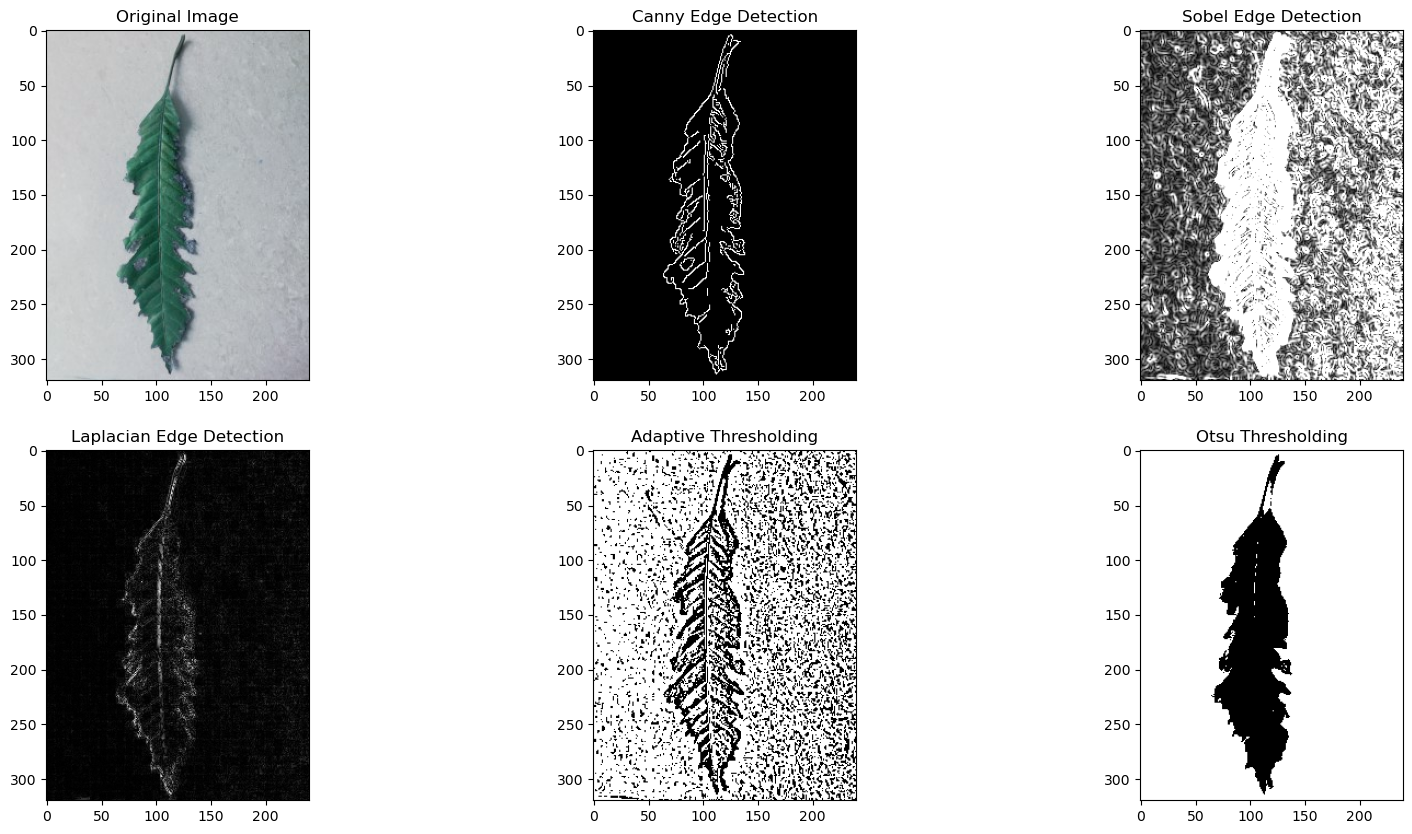

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    img = cv2.imread(image_path)
    
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}. Please check the path.")
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, img_rgb

def sobel_edge_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined = cv2.sqrt(sobelx**2 + sobely**2)
    sobel_combined = cv2.convertScaleAbs(sobel_combined)
    return sobel_combined

def laplacian_edge_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)
    return laplacian

def adaptive_thresholding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                            cv2.THRESH_BINARY, 11, 2)
    return adaptive_thresh

def otsu_thresholding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu_thresh

def process_multiple_filters(img):
    canny_edges = cv2.Canny(img, 100, 200)
    sobel_edges = sobel_edge_detection(img)
    laplacian_edges = laplacian_edge_detection(img)
    adaptive_thresh = adaptive_thresholding(img)
    otsu_thresh = otsu_thresholding(img)
    
    return canny_edges, sobel_edges, laplacian_edges, adaptive_thresh, otsu_thresh

def display_filters(img, canny, sobel, laplacian, adaptive, otsu):
    plt.figure(figsize=(20, 10))
    
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    
    plt.subplot(2, 3, 2)
    plt.imshow(canny, cmap='gray')
    plt.title("Canny Edge Detection")
    
    plt.subplot(2, 3, 3)
    plt.imshow(sobel, cmap='gray')
    plt.title("Sobel Edge Detection")
    
    plt.subplot(2, 3, 4)
    plt.imshow(laplacian, cmap='gray')
    plt.title("Laplacian Edge Detection")
    
    plt.subplot(2, 3, 5)
    plt.imshow(adaptive, cmap='gray')
    plt.title("Adaptive Thresholding")
    
    plt.subplot(2, 3, 6)
    plt.imshow(otsu, cmap='gray')
    plt.title("Otsu Thresholding")
    
    plt.show()

def detect_disease_with_multiple_filters(image_path):
    img, img_rgb = load_image(image_path)
    
    # Apply multiple filters
    canny, sobel, laplacian, adaptive, otsu = process_multiple_filters(img)
    
    # Display all filters
    display_filters(img_rgb, canny, sobel, laplacian, adaptive, otsu)

# Call the function
try:
    detect_disease_with_multiple_filters('uploads/IMG_20211106_120844 (Custom).jpg')
except FileNotFoundError as e:
    print(e)
